In [1]:
import torch
import torchaudio
import PIL.Image
import matplotlib.pyplot as plt
import einops
from torchvision.transforms.v2 import ToPILImage, PILToTensor, CenterCrop
from IPython.display import Audio as play
from datasets import load_dataset, Audio
from tft.mdct import mdct, inverse_mdct, mdct2d, inverse_mdct2d
from tft.utils import compand, decompand

In [2]:
esc50 = load_dataset("danjacobellis/esc_50",split='train').cast_column('opus', Audio(decode=False))

In [3]:
x, fs = torchaudio.load(esc50[29]['opus']['bytes'],normalize=False);
assert fs==48000; assert x.min() >= -1.0; assert x.max() <= 1.0
n_frames = 448
n_freq = 512
x = x[0,:((n_frames+1)*n_freq)]
play(x,rate=48000)

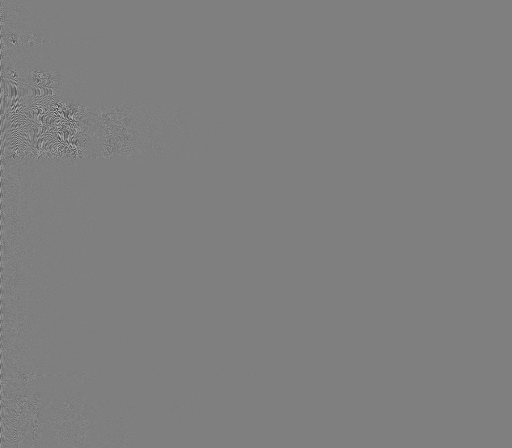

In [4]:
X = compand(mdct(
    signals = x,
    frame_length = 2*n_freq,
))/10
X = CenterCrop((X.shape[0]+32,X.shape[1]+32))(X)
ξ = compand(mdct2d(X, 64, 64))/10
ξ2 = (255*ξ).round().clamp(-127,127)/255
X_hat = inverse_mdct2d(decompand(ξ2*10))
X_hat = CenterCrop((X.shape[0]-32,X.shape[1]-32))(X_hat)
display(ToPILImage()(X_hat/2 + 0.5))
x_hat_hat = inverse_mdct(
    mdcts = decompand(10*X_hat),
)
display(play(x_hat_hat,rate=fs))

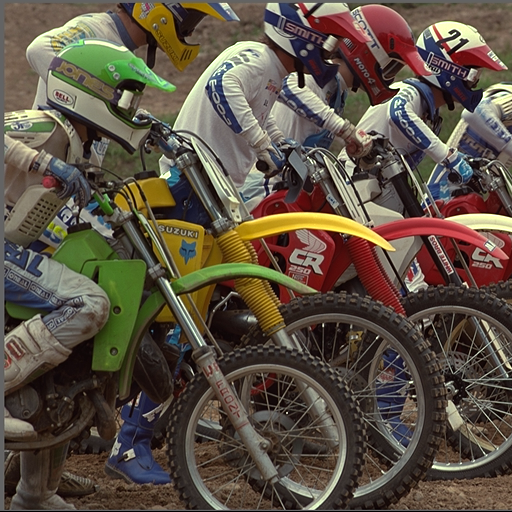

In [5]:
img = PIL.Image.open("kodim05.png").crop((0,0,512,512))
y = PILToTensor()(img).to(torch.float) / 127.5 - 1.0
y = CenterCrop((y.shape[1]+32, y.shape[2]+32))(y)
Y = compand(mdct2d(y, 16, 16))/40
Y2 = (255*Y).round().clamp(-127,127)/255
y_hat = inverse_mdct2d(decompand(40*Y2))
y_hat = CenterCrop((y.shape[1]-32, y.shape[2]-32))(y)
ToPILImage()((y_hat/2).clamp(-0.5,0.5)+0.5)

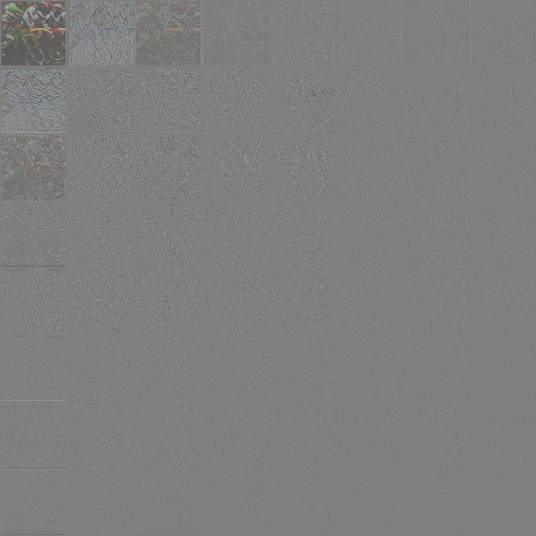

In [6]:
ToPILImage()(einops.rearrange(Y2.clamp(-0.5,0.5),'c h w u v -> c (u h) (v w)')+0.5)

In [225]:
%env CUDA_VISIBLE_DEVICES=MIG-3b1def15-1f21-5622-ac8e-57509b6b0cf0
device="cuda:0"
import torch
import torch.nn as nn
from timm.optim import Mars
from fastprogress import progress_bar
import io

class PerChannelNoiseScale(nn.Module):
    def __init__(self, num_channels, total_scale=4.0):
        super().__init__()
        self.num_channels = num_channels
        self.alpha = nn.Parameter(torch.zeros(num_channels))
        self.min_scale = 1.0
        self.total_scale = total_scale

    def forward(self):
        exp_alpha = torch.exp(self.alpha)
        alpha_sum = exp_alpha.sum()
        total_excess = (self.total_scale - self.min_scale) * self.num_channels
        S_prime = total_excess * (exp_alpha / alpha_sum)
        return self.min_scale + S_prime

class NoiseInjectionModel(nn.Module):
    def __init__(self, num_channels, total_scale=4.0):
        super().__init__()
        self.num_channels = num_channels
        self.noise_scales = PerChannelNoiseScale(num_channels, total_scale)
        self.hardtanh = nn.Hardtanh(min_val=-127.49, max_val=127.49)

    def forward(self, x):
        if self.training:
            S = self.noise_scales() 
            S_half = (S / 2.0).view(1, -1, 1, 1)
            noise = (torch.rand_like(x) * 2.0 - 1.0) * S_half
            x = x + noise
            x = self.hardtanh(x)
            return x
        else:
            S = self.noise_scales() 
            S_view = S.view(1, -1, 1, 1)
            x = self.hardtanh(x)
            x = x / S_view
            x = torch.round(x)
            return x

    def scale(self, x_int):
        S = self.noise_scales()
        S_view = S.view(1, -1, 1, 1)
        x_float = x_int * S_view
        x_float = self.hardtanh(x_float)
        return x_float

env: CUDA_VISIBLE_DEVICES=MIG-3b1def15-1f21-5622-ac8e-57509b6b0cf0


In [226]:
img = PIL.Image.open("kodim05.png").crop((0,0,512,512))
y = PILToTensor()(img).to(torch.float) / 127.5 - 1.0
y = y.to(device)

_, num_channels, height, width = X_in.shape
model = NoiseInjectionModel(num_channels, total_scale=8).to(device)
optimizer = Mars(model.parameters(), lr=1e-1, caution=True)
losses = []
val_loss = []
model.train()

pb = progress_bar(range(100))
for i_step in pb:
    
    y_padded = CenterCrop((y.shape[1]+32, y.shape[2]+32))(y)
    Y = compand(mdct2d(y_padded, 16, 16))/40

    inputs = einops.rearrange(256*Y, 'c h w u v -> (c u v) h w').unsqueeze(0)
    outputs = einops.rearrange(
        model(inputs).squeeze(0),
        '(c u v) h w -> c h w u v',
        u=Y.shape[3],
        v=Y.shape[4]
    )/256
    
    y_hat = inverse_mdct2d(decompand(40*outputs))
    y_hat = CenterCrop((y.shape[1], y.shape[2]))(y_hat)
 
    loss = torch.nn.functional.mse_loss(y,y_hat)
    losses.append(loss.item())
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    pb.comment = f"Loss: {loss.item():.4f}"

 |████████████████████████████████████████| 100.00% [100/100 01:07<00:00 Loss: 0.0050]

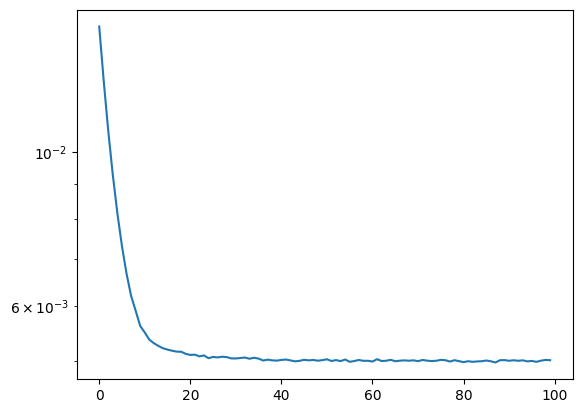

In [227]:
plt.semilogy(losses)

In [228]:
def entropy_code(ints):
    webp_bytes = []
    for sample in ints:
        webp_bytes.append([])
        for channel in sample:
            img = ToPILImage()((channel+127).to(torch.uint8))
            buff = io.BytesIO()
            img.save(buff, format='WEBP', lossless=True)
            webp_bytes[-1].append(buff.getbuffer())
    return webp_bytes
    
def entropy_decode(webp_bytes):
    batch_out = []
    for sample_buffers in webp_bytes:
        channel_tensors = []
        for buff in sample_buffers:
            with io.BytesIO(buff) as memfile:
                img = PIL.Image.open(memfile).convert('L') 
            t = PILToTensor()(img)
            t = t.to(torch.int16) - 127
            t = t.squeeze(0)
            channel_tensors.append(t)
        
        sample_tensor = torch.stack(channel_tensors, dim=0)
        batch_out.append(sample_tensor.unsqueeze(0))
    decoded = torch.cat(batch_out, dim=0)
    return decoded

184.258 KB
4.268102334769725 compression ratio


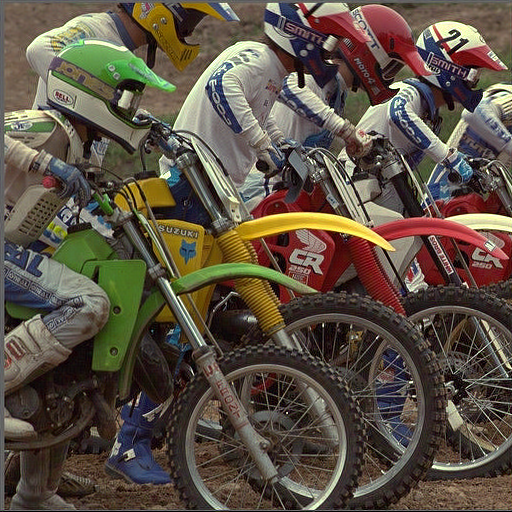

In [229]:
model.eval()
y_padded = CenterCrop((y.shape[1]+32, y.shape[2]+32))(y)
Y = compand(mdct2d(y_padded, 16, 16))/40

inputs = einops.rearrange(256*Y, 'c h w u v -> (c u v) h w').unsqueeze(0)
outputs_int = model(inputs)  
webp_bytes = entropy_code(outputs_int)
size_bytes = sum( sum(len(b) for b in group) for group in webp_bytes)
print(f"{size_bytes/1e3} KB")
print(f"{y.numel()/size_bytes} compression ratio")
decoded_ints = entropy_decode(webp_bytes)
outputs = model.scale(decoded_ints.to(device))

outputs = einops.rearrange(
    outputs.squeeze(0),
    '(c u v) h w -> c h w u v',
    u=Y.shape[3],
    v=Y.shape[4]
)/256

y_hat = inverse_mdct2d(decompand(40*outputs))
y_hat = CenterCrop((y.shape[1], y.shape[2]))(y_hat)
ToPILImage()((y_hat/2).clamp(-0.5,0.5)+0.5)

In [230]:
img = PIL.Image.open("kodim05.png").crop((0,0,512,512))
y = PILToTensor()(img).to(torch.float) / 127.5 - 1.0
y = y.to(device)

_, num_channels, height, width = X_in.shape
model = NoiseInjectionModel(num_channels, total_scale=16).to(device)
optimizer = Mars(model.parameters(), lr=1e-1, caution=True)
losses = []
val_loss = []
model.train()

pb = progress_bar(range(100))
for i_step in pb:
    
    y_padded = CenterCrop((y.shape[1]+32, y.shape[2]+32))(y)
    Y = compand(mdct2d(y_padded, 16, 16))/40

    inputs = einops.rearrange(256*Y, 'c h w u v -> (c u v) h w').unsqueeze(0)
    outputs = einops.rearrange(
        model(inputs).squeeze(0),
        '(c u v) h w -> c h w u v',
        u=Y.shape[3],
        v=Y.shape[4]
    )/256
    
    y_hat = inverse_mdct2d(decompand(40*outputs))
    y_hat = CenterCrop((y.shape[1], y.shape[2]))(y_hat)
 
    loss = torch.nn.functional.mse_loss(y,y_hat)
    losses.append(loss.item())
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    pb.comment = f"Loss: {loss.item():.4f}"

 |████████████████████████████████████████| 100.00% [100/100 01:07<00:00 Loss: 0.0324]

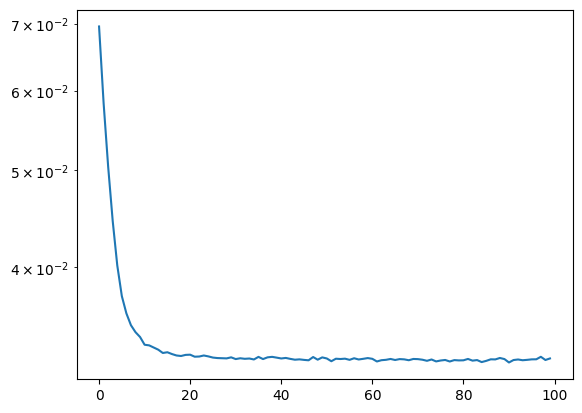

In [231]:
plt.semilogy(losses)

94.866 KB
8.28992473594333 compression ratio


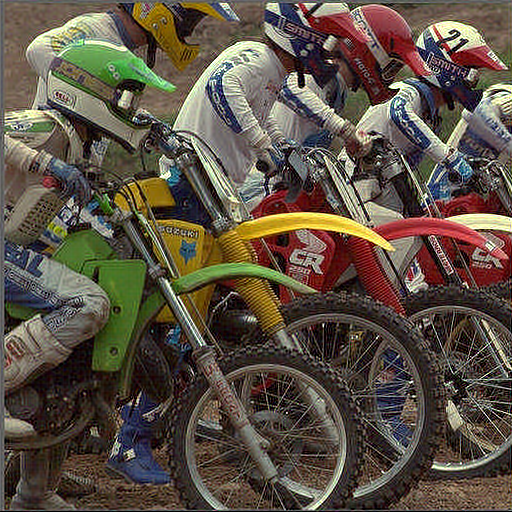

In [232]:
model.eval()
y_padded = CenterCrop((y.shape[1]+32, y.shape[2]+32))(y)
Y = compand(mdct2d(y_padded, 16, 16))/40

inputs = einops.rearrange(256*Y, 'c h w u v -> (c u v) h w').unsqueeze(0)
outputs_int = model(inputs)  
webp_bytes = entropy_code(outputs_int)
size_bytes = sum( sum(len(b) for b in group) for group in webp_bytes)
print(f"{size_bytes/1e3} KB")
print(f"{y.numel()/size_bytes} compression ratio")
decoded_ints = entropy_decode(webp_bytes)
outputs = model.scale(decoded_ints.to(device))

outputs = einops.rearrange(
    outputs.squeeze(0),
    '(c u v) h w -> c h w u v',
    u=Y.shape[3],
    v=Y.shape[4]
)/256

y_hat = inverse_mdct2d(decompand(40*outputs))
y_hat = CenterCrop((y.shape[1], y.shape[2]))(y_hat)
ToPILImage()((y_hat/2).clamp(-0.5,0.5)+0.5)

In [237]:
img = PIL.Image.open("kodim05.png").crop((0,0,512,512))
y = PILToTensor()(img).to(torch.float) / 127.5 - 1.0
y = y.to(device)

_, num_channels, height, width = X_in.shape
model = NoiseInjectionModel(num_channels, total_scale=30).to(device)
optimizer = Mars(model.parameters(), lr=1e-1, caution=True)
losses = []
val_loss = []
model.train()

pb = progress_bar(range(100))
for i_step in pb:
    
    y_padded = CenterCrop((y.shape[1]+32, y.shape[2]+32))(y)
    Y = compand(mdct2d(y_padded, 16, 16))/40

    inputs = einops.rearrange(256*Y, 'c h w u v -> (c u v) h w').unsqueeze(0)
    outputs = einops.rearrange(
        model(inputs).squeeze(0),
        '(c u v) h w -> c h w u v',
        u=Y.shape[3],
        v=Y.shape[4]
    )/256
    
    y_hat = inverse_mdct2d(decompand(40*outputs))
    y_hat = CenterCrop((y.shape[1], y.shape[2]))(y_hat)
 
    loss = torch.nn.functional.mse_loss(y,y_hat)
    losses.append(loss.item())
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    pb.comment = f"Loss: {loss.item():.4f}"

 |████████████████████████████████████████| 100.00% [100/100 01:08<00:00 Loss: 0.2415]

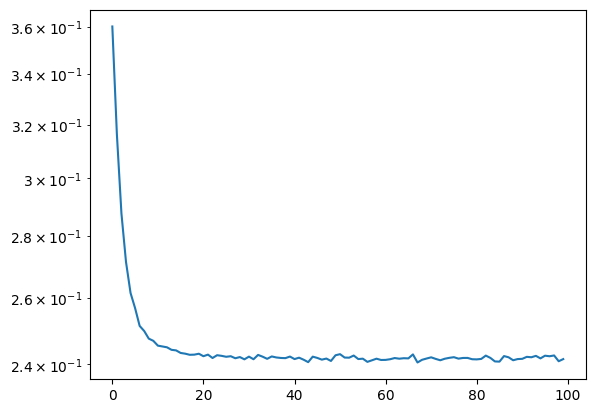

In [238]:
plt.semilogy(losses)

38.822 KB
20.257379836175364 compression ratio


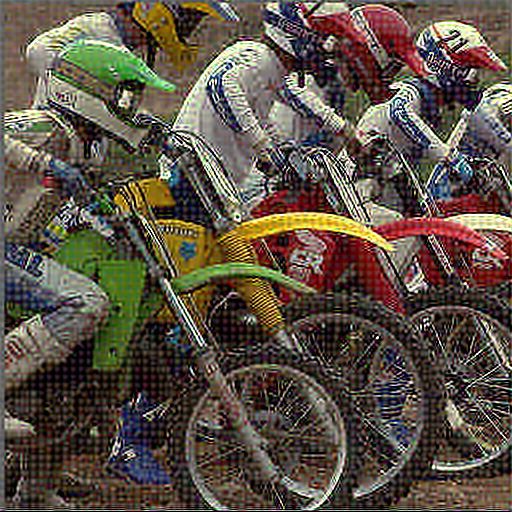

In [239]:
model.eval()
y_padded = CenterCrop((y.shape[1]+32, y.shape[2]+32))(y)
Y = compand(mdct2d(y_padded, 16, 16))/40

inputs = einops.rearrange(256*Y, 'c h w u v -> (c u v) h w').unsqueeze(0)
outputs_int = model(inputs)  
webp_bytes = entropy_code(outputs_int)
size_bytes = sum( sum(len(b) for b in group) for group in webp_bytes)
print(f"{size_bytes/1e3} KB")
print(f"{y.numel()/size_bytes} compression ratio")
decoded_ints = entropy_decode(webp_bytes)
outputs = model.scale(decoded_ints.to(device))

outputs = einops.rearrange(
    outputs.squeeze(0),
    '(c u v) h w -> c h w u v',
    u=Y.shape[3],
    v=Y.shape[4]
)/256

y_hat = inverse_mdct2d(decompand(40*outputs))
y_hat = CenterCrop((y.shape[1], y.shape[2]))(y_hat)
ToPILImage()((y_hat/2).clamp(-0.5,0.5)+0.5)